In [2]:
import lal


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft, ifft
from scipy import signal
from scipy.fft import fftshift
import scipy

from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_td_waveform,get_fd_waveform

#from pycbc.filter import highpass_fir, matched_filter
#from pycbc.filter import hxighpass_fir, lowpass_fir
from pycbc.psd import welch, interpolate
import pycbc.noise
import pycbc.psd
from pycbc.detector import Detector


import pylab
from pycbc import types, waveform, frame

# from sklearn.utils import shuffle

from scipy.interpolate import interp1d

from nnAudio import Spectrogram
import torch

from torchvision import transforms 
#import cv2

from skimage import transform as trans

import random

/home/rdey/ENV_lalsuite/lib/python3.9/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [15]:
# Functions

def whitening_func(L1,noise):

    L1_ts=types.TimeSeries(L1, delta_t=1.0 / 4096)
    N_ts=types.TimeSeries(noise, delta_t=1.0 / 4096)
    
    psdL1 = interpolate(welch(N_ts), 1.0 / L1_ts.duration)

    L1_white = (L1_ts.to_frequencyseries() / psdL1 ** 0.5).to_timeseries()

    return L1_white

# waveform generation

In [ ]:
def waveform_multi(m1=50,m2=50,a1=0,a2=0,end_time = 1272529720,declination = 0.65, right_ascension = 4.67,polarization = 2.34):

    hp, hc = get_td_waveform(approximant='IMRPhenomXAS',
                                 mass1=m1,
                                 mass2=m2,
                                 spin1z=a1,
                                 spin2z=a2,
                                 delta_t=1.0/4096,
                                 distance=1000,
                                 f_lower=8)
    
    
    
    det_h1 = Detector('H1')
    det_l1 = Detector('L1')
    det_v1 = Detector('V1')

    # Choose a GPS end time, sky location, and polarization phase for the merger
    # NOTE: Right ascension and polarization phase runs from 0 to 2pi
    #       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.
    # end_time = 1272529720
    # declination = 0.65
    # right_ascension = 4.67
    # polarization = 2.34
    hp.start_time += end_time
    hc.start_time += end_time

    signal_h1 = det_h1.project_wave(hp,hc,  right_ascension, declination, polarization)
    signal_l1 = det_l1.project_wave(hp, hc, right_ascension, declination, polarization)
    signal_v1 = det_v1.project_wave(hp, hc,  right_ascension, declination, polarization)

    signal_h1_np=np.array(signal_h1)
    signal_l1_np=np.array(signal_l1)
    signal_v1_np=np.array(signal_v1)
    
    signal_h1_np=signal_h1_np[-2*4096:]
    signal_l1_np=signal_l1_np[-2*4096:]
    signal_v1_np=signal_v1_np[-2*4096:]
    

    signal_ALL=np.array([signal_l1_np.tolist(),signal_h1_np.tolist(),signal_v1_np.tolist()])
    
    return signal_ALL



## parameters

In [3]:
m1array=np.linspace(5,100,96)
qarray=np.linspace(1/4,8,50)

m2list=[]
m1list=[]

for i in m1array:
    for j in qarray:
        m2=i*j
        if 5<=m2<= 100:
            m2list.append(m2)
            m1list.append(i)

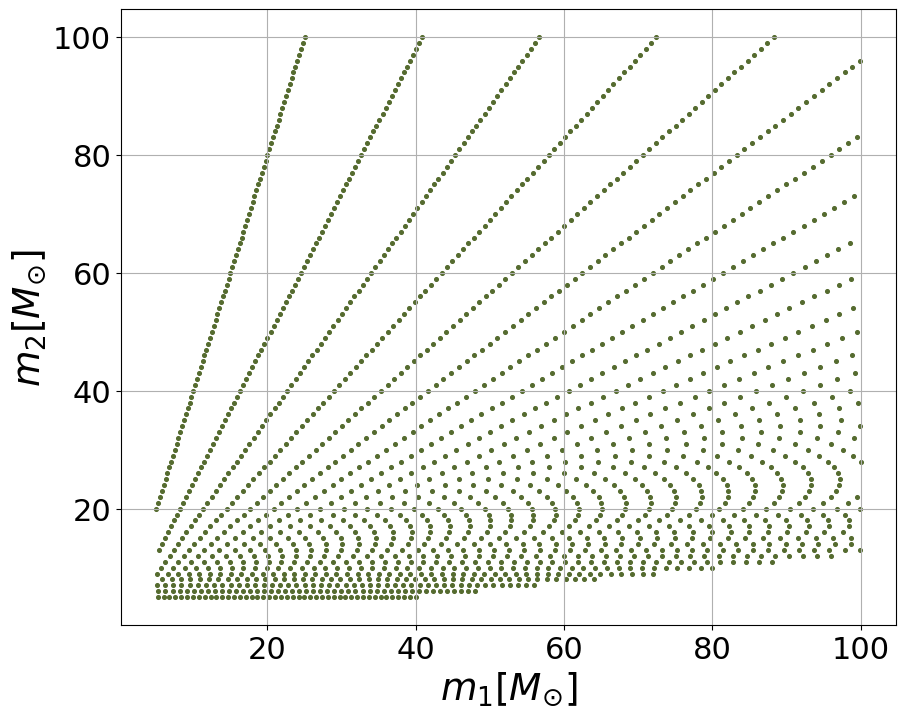

In [5]:
plt.figure(figsize=(10,8))
plt.scatter(m2list,m1list,c="darkolivegreen",s=7)
plt.xlabel('$m_1 [M_{\odot}]$',fontsize=27)
plt.ylabel('$m_2 [M_{\odot}]$',fontsize=27)
plt.rc('xtick', labelsize=22)    
plt.rc('ytick', labelsize=22)
plt.grid()

In [6]:
M1=[]
M2=[]
a1=[]
a2=[]
for i in range(0,len(m2list)):
    for j in range(0,100):

        M1.append(m1list[i])
        M2.append(m2list[i])

        a1.append(random.uniform(-0.8,0.8))
        a2.append(random.uniform(-0.8,0.8))

In [8]:
# convert to dataframe and save

df2=pd.DataFrame()

df2['m1']=M1
df2['m2']=M2
df2['a1']=a1
df2['a2']=a2

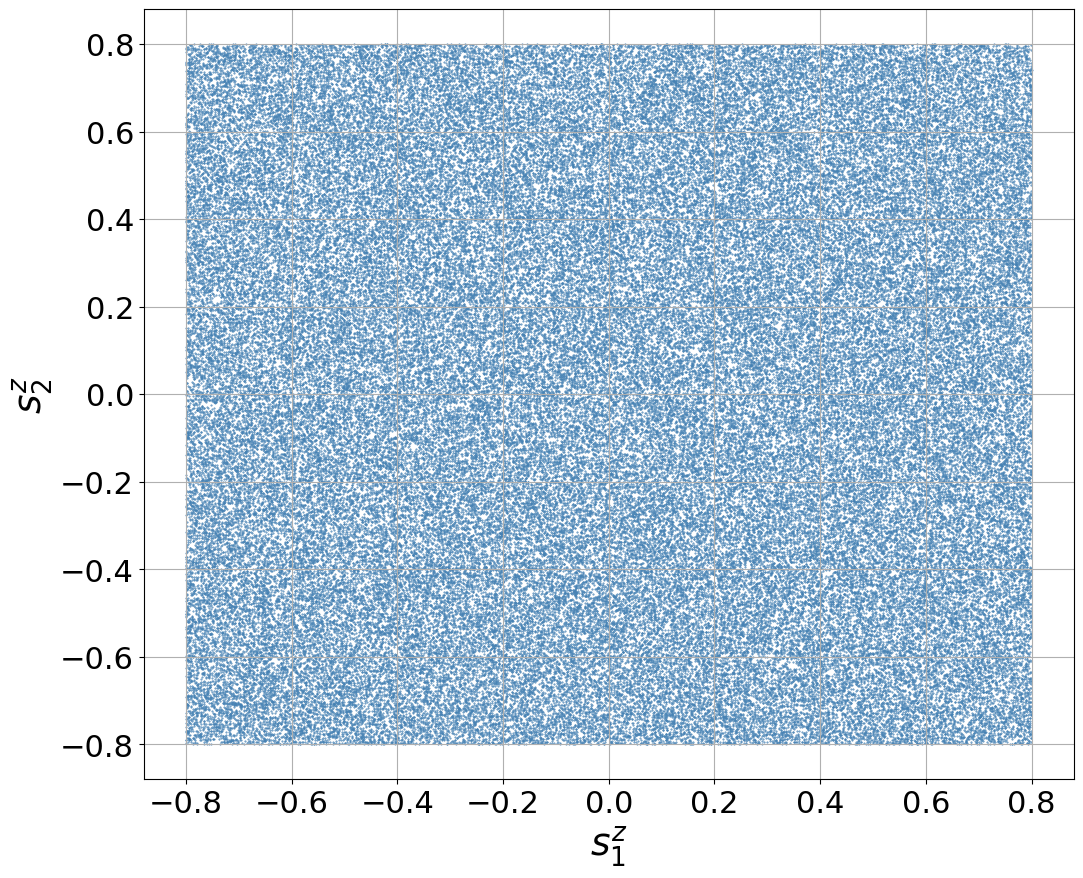

In [9]:
plt.figure(figsize=(12,10))
plt.scatter(df2['a1'],df2['a2'],c="steelblue",s=.2)
plt.xlabel('$s_1^z$',fontsize=27)
plt.ylabel('$s_2^z$',fontsize=27)
plt.rc('xtick', labelsize=22)    
plt.rc('ytick', labelsize=22)
plt.grid()

In [10]:
GPS_time_lst=[]
declination_lst=[]
right_ascension_lst=[]
polarization_lst=[]

random.seed(30)

for i in range(0,200000):
    GPS_time=random.randint(1238303737,1268903511)
    declination = random.uniform(-1.56,1.56)
    right_ascension = random.uniform(0,6.1)
    polarization = random.uniform(0,6.1)
    
    GPS_time_lst.append(GPS_time)
    declination_lst.append(declination)
    right_ascension_lst.append(right_ascension)
    polarization_lst.append(polarization)

In [11]:
dfsky=pd.DataFrame()

dfsky['GPS_time']=GPS_time_lst
dfsky['declination']=declination_lst
dfsky['right_ascension']=right_ascension_lst
dfsky['polarization']=polarization_lst

#dfsky.to_csv('sky_loc_params.csv')

# generate from given params

In [ ]:
df2s=pd.read_csv('Waveform_params.csv')  
dfskyr=pd.read_csv('sky_loc_params.csv')  

In [ ]:
for i in range(0,150000):
    
    m1=df2s['m1'].iloc[i]
    m2=df2s['m2'].iloc[i] 
    a1=df2s['a1'].iloc[i]
    a2=df2s['a2'].iloc[i]
    
    end_time=dfskyr['GPS_time'].iloc[i]
    declination=dfskyr['declination'].iloc[i]
    right_ascension=dfskyr['right_ascension'].iloc[i]
    polarization=dfskyr['polarization'].iloc[i]
    
    w=waveform_multi(m1,m2,a1,a2, end_time, declination, right_ascension, polarization)
    
    #np.save('/Users/ramitdey/Documents/Documents/3detector_waveform/'+str(i)+'.npy',w)

In [3]:
# TEST
x=np.load('/home/rdey/scratch/waveforms/1/92.npy')

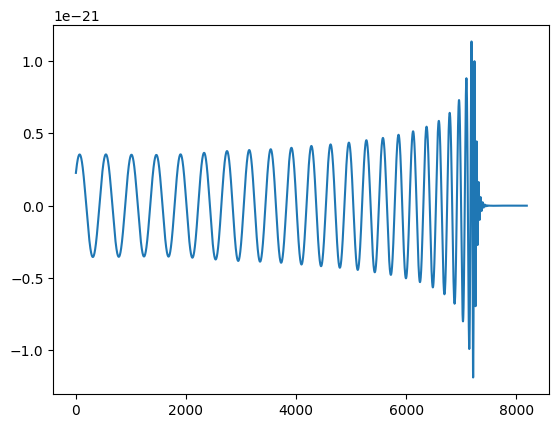

In [4]:
plt.plot(x[0])

# PYCBC Noise

In [13]:


####### using pycbc PSDs  #######
# The color of the noise matches a PSD which you provide
flow = 10.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)




####### Using a psd from LIGO data ########
#E.g using V1 noise 

#pathV1a='/.../V-V1_GWOSC_O3b_4KHZ_R1-1266966528-4096.gwf'
#rawV1noise4096 = frame.read_frame(pathV1a, 'V1:GWOSC-4KHZ_R1_STRAIN') #load and read noise

#V1noise4096=np.array(rawV1noise4096)
#V1noise_ts=types.TimeSeries(V1noise4096, delta_t=1.0 / 4096) #convert it to pycbc timeseries

#psdV1 = interpolate(welch(V1noise_ts), 1.0 / V1noise_ts.duration) #generate the psd

####################################################


######## Generate 2 seconds of noise at 4096 Hz ######
time_len=2
delta_t = 1.0 / 4096
tsamples = int(time_len / delta_t)

for i in range(10001):
    ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=i)
    np.save('/home/rdey/scratch/waveforms/pycbc_N1/'+str(i)+'P_N.npy',ts)

In [4]:
xN=np.load('/home/rdey/scratch/waveforms/pycbc_N1/1P_N.npy')

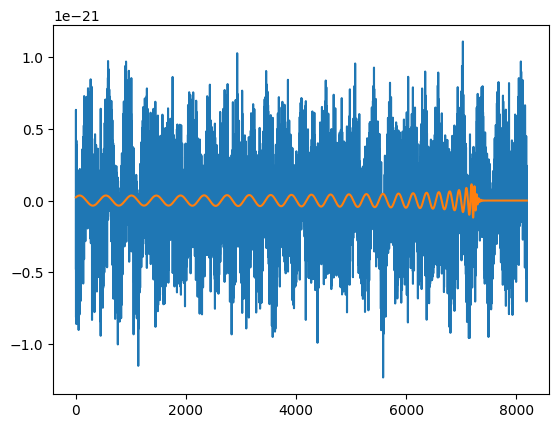

In [6]:
plt.plot(xN)
plt.plot(x[0]/10)

# Noise+event spectrogram

In [17]:



#CQT1992v2    ,CQT2010v2

class cqt:
    def __init__(self):
        #self.cqt_transform = Spectrogram.CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=6,
                                                   #bins_per_octave=9,filter_scale=1,window='hann')
        #self.cqt_transform = Spectrogram.CQT1992v2(sr=4096, fmin=10, fmax=800, hop_length=32,window='hann')
        
        self.cqt_transform = Spectrogram.CQT1992v2(sr=4096, fmin=15, fmax=500, hop_length=6,
                                    bins_per_octave=52, norm=1, filter_scale=.1,window='hann')


    def run_cqt_transform(self,x) -> torch.Tensor:
        # We stack the passed x since there are 3
        # time series per file.
        #x = np.hstack(x)
        # Normalize (is there a better way?)
        x = x / np.max(x)
        x = torch.from_numpy(x).float()
        return self.cqt_transform(x)
    
    
    def __call__(self,sample):

        inputs = sample
        strain_H1 = sample
        
    
    
    
        spectrogram_H1 = self.run_cqt_transform(strain_H1)[0]


        #resize the output
        
        res=int(128)
        
        #spectrogram_H1=trans.resize(spectrogram_H1, (res, res), order=4,preserve_range=True)
        

        return spectrogram_H1




In [ ]:
cqts=cqt()


for i in range(1000):
    x=np.load('/home/rdey/scratch/waveforms/1/'+str(i)+'.npy')
    xN=np.load('/home/rdey/scratch/waveforms/pycbc_N1/'+str(i)+'P_N.npy')
    
    event=x[0]+xN
    #Wevent=whitening_func(event,event)
    #W_wave=whitening_func(x[0],xN)
    
    img_wave=cqts(x[0])
    img_event=cqts(event)
    
    torch.save(img_wave,'/home/rdey/scratch/waveforms/spect_wave/s_w_'+str(i)+'.pt')
    torch.save(img_event,'/home/rdey/scratch/waveforms/spect_event/s_e_'+str(i)+'.pt')
    

    
    
    
    
    
    

CQT kernels created, time used = 0.0778 seconds


In [18]:
cqts=cqt()


CQT kernels created, time used = 0.0802 seconds


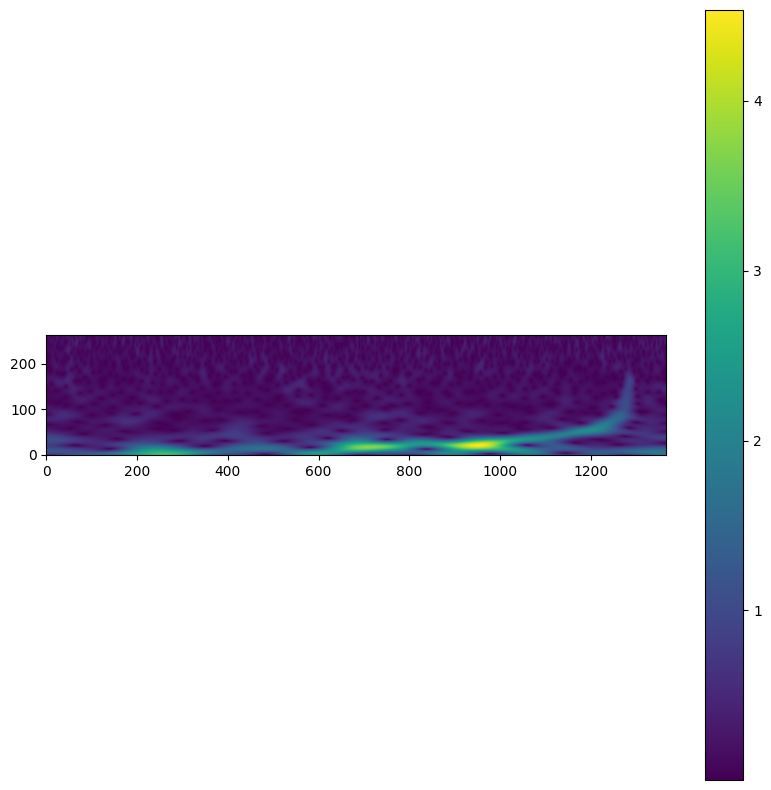

In [21]:

img=cqts(event)
#img,_=cqt((temp_data,0))

#resize = transforms.Compose([transforms.Resize((256,256))])


plt.figure(figsize=(10,10))
plt.imshow(img,origin='lower')
plt.colorbar()


In [93]:
torch.save(img,'event.pt')

In [12]:
test=torch.load('/home/rdey/scratch/waveforms/spect_wave/s_w_99.pt')
teste=torch.load('/home/rdey/scratch/waveforms/spect_event/s_e_99.pt')

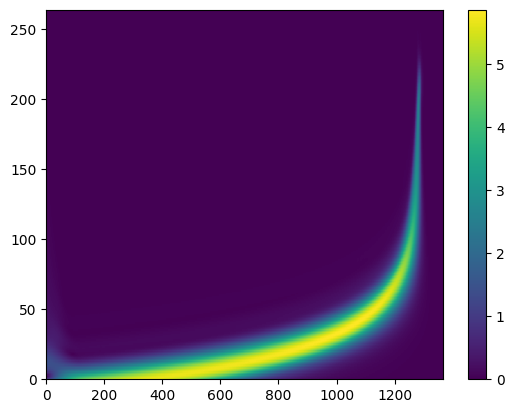

In [13]:
plt.pcolor(test)
plt.colorbar()

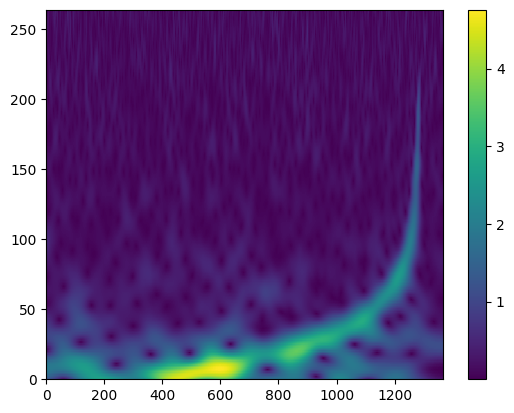

In [14]:
plt.pcolor(teste)
plt.colorbar()